# Base experiment notebook

This notebook is the template for all experiments.

It contains the basic code to run an experiment, and it is the starting point for all other notebooks in the folder `experiments`.

## Setup and Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from pytorch_lightning import callbacks, seed_everything
from tensorboard.backend.event_processing import event_accumulator
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    calculate_metrics_binary,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_precision_recall_curve_binary,
    plot_roc_curve,
    plot_roc_curve_binary,
)

In [ ]:
seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

## Definition of the notebook variables

In [ ]:
# To change between experiments
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

BATCH_SIZE = 512
MAX_EPOCHS = 50


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False


### Definition of the net architecture
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, n_classes=2, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, embed_dim),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, inter_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inter_dim, n_classes),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits


MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
INPUT_DIM = 768
HIDDEN_DIM = 768
NUM_CLASSES = 2
DROPOUT = 0.2
DROP_CENTER = NUM_CLASSES == 2
FREEZE = True
MIN_DELTA = 0.001

## Adam

### Experiment definition

In [ ]:
OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {"betas": (0.91, 0.997)}
LR = 1e-3
LOSS = "CrossEntropyLoss"

# SCHEDULER_KWARGS = {
#     "scheduler": "ReduceLROnPlateau",
#     "monitor": "val_loss",
#     "mode": "min",
#     "factor": 0.1,
# }

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.93,
}

POSTFIX = "ExponentialLR-0.93-(0.91, 0.997)"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

### Training

In [ ]:
trainer.fit(lit_model);

### Evaluation and visualization

In [ ]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## AdamW

### Experiment definition

In [15]:
OPTIMIZER_TYPE = "AdamW"
OPTIMIZER_KWARGS = {"amsgrad": True, "weight_decay": 0.01}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.92,
}

POSTFIX = "ExponentialLR-amsgrad"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [16]:
trainer.fit(lit_model);

Missing logger folder: ../../results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_

Output()

Metric val_loss improved. New best score: 0.571
Epoch 0, global step 306: 'val_loss' reached 0.57064 (best 0.57064), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=0-step=306.ckpt' as top 1


Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.558
Epoch 1, global step 612: 'val_loss' reached 0.55808 (best 0.55808), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=1-step=612.ckpt' as top 1


Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.541
Epoch 2, global step 918: 'val_loss' reached 0.54115 (best 0.54115), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=2-step=918.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.533
Epoch 3, global step 1224: 'val_loss' reached 0.53301 (best 0.53301), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=3-step=1224.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.532
Epoch 4, global step 1530: 'val_loss' reached 0.53171 (best 0.53171), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=4-step=1530.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.525
Epoch 5, global step 1836: 'val_loss' reached 0.52496 (best 0.52496), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=5-step=1836.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.517
Epoch 6, global step 2142: 'val_loss' reached 0.51653 (best 0.51653), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=6-step=2142.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.515
Epoch 7, global step 2448: 'val_loss' reached 0.51509 (best 0.51509), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=7-step=2448.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.509
Epoch 8, global step 2754: 'val_loss' reached 0.50924 (best 0.50924), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=8-step=2754.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.507
Epoch 9, global step 3060: 'val_loss' reached 0.50721 (best 0.50721), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=9-step=3060.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.505
Epoch 10, global step 3366: 'val_loss' reached 0.50483 (best 0.50483), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=10-step=3366.ckpt' as top 1


Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.502
Epoch 11, global step 3672: 'val_loss' reached 0.50177 (best 0.50177), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=11-step=3672.ckpt' as top 1


Epoch 12, global step 3978: 'val_loss' was not in top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.501
Epoch 13, global step 4284: 'val_loss' reached 0.50070 (best 0.50070), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=13-step=4284.ckpt' as top 1


Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.499
Epoch 14, global step 4590: 'val_loss' reached 0.49902 (best 0.49902), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=14-step=4590.ckpt' as top 1


Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.498
Epoch 15, global step 4896: 'val_loss' reached 0.49779 (best 0.49779), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=15-step=4896.ckpt' as top 1


Epoch 16, global step 5202: 'val_loss' was not in top 1


Epoch 17, global step 5508: 'val_loss' was not in top 1


Epoch 18, global step 5814: 'val_loss' reached 0.49759 (best 0.49759), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=18-step=5814.ckpt' as top 1


Epoch 19, global step 6120: 'val_loss' reached 0.49679 (best 0.49679), saving model to '/home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=19-step=6120.ckpt' as top 1


Epoch 20, global step 6426: 'val_loss' was not in top 1


Epoch 21, global step 6732: 'val_loss' was not in top 1


Epoch 22, global step 7038: 'val_loss' was not in top 1


Epoch 23, global step 7344: 'val_loss' was not in top 1


Epoch 24, global step 7650: 'val_loss' was not in top 1


Epoch 25, global step 7956: 'val_loss' was not in top 1


Epoch 26, global step 8262: 'val_loss' was not in top 1


Epoch 27, global step 8568: 'val_loss' was not in top 1


Epoch 28, global step 8874: 'val_loss' was not in top 1


Epoch 29, global step 9180: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 15 records. Best score: 0.498. Signaling Trainer to stop.
Epoch 30, global step 9486: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=19-step=6120.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/gwatk/Documents/MVA/DL/NLP_Assemblee/results/optimizer_selection/AdamW_0.001_ExponentialLR-amsgrad/lightning_logs/epoch=19-step=6120.ckpt


Output()

Metrics:  {'log_loss': 0.4911186775918859, 'accuracy': 0.7531110376523529, 'balanced_accuracy': 0.742076629822453, 'recall': 0.6744915124636794, 'precision': 0.7182249966074095, 'f1_score': 0.695671604516358, 'AUC': 0.8347551719563849, 'jaccard_weighted': 0.5333561754272815, 'matthews_weighted': 0.4890086013343393, 'hamming_loss': 0.24688896234764712, 'confusion_matrix': [[44163, 10382], [12771, 26463]], 'confusion_matrix_true_normed': [[0.8096617471812265, 0.19033825281877348], [0.32550848753632056, 0.6744915124636794]], 'confusion_matrix_pred_normed': [[0.7756876383180524, 0.2817750033925906], [0.22431236168194751, 0.7182249966074095]], 'confusion_matrix_all_normed': [[0.47092632678957974, 0.11070708794079698], [0.13618187440685015, 0.28218471086277314]]}


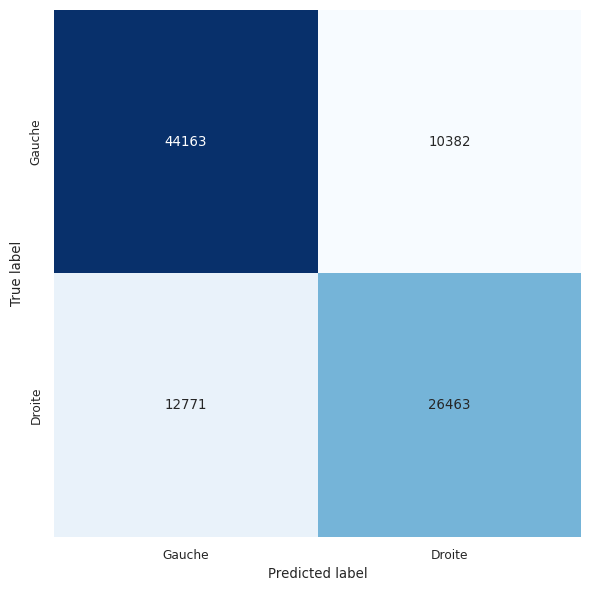

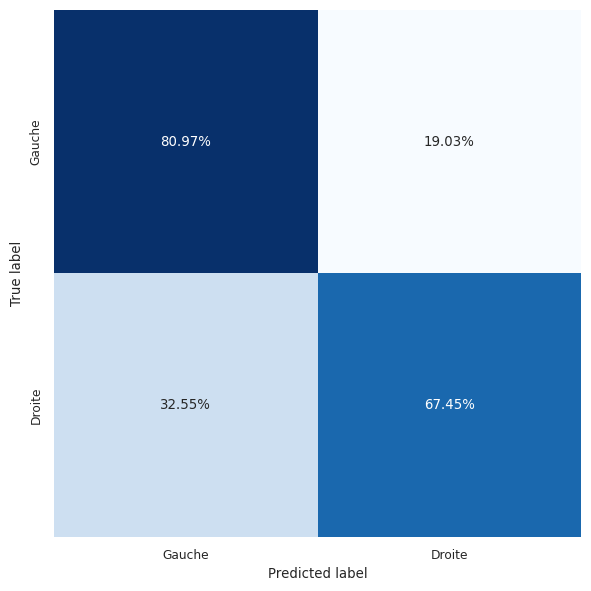

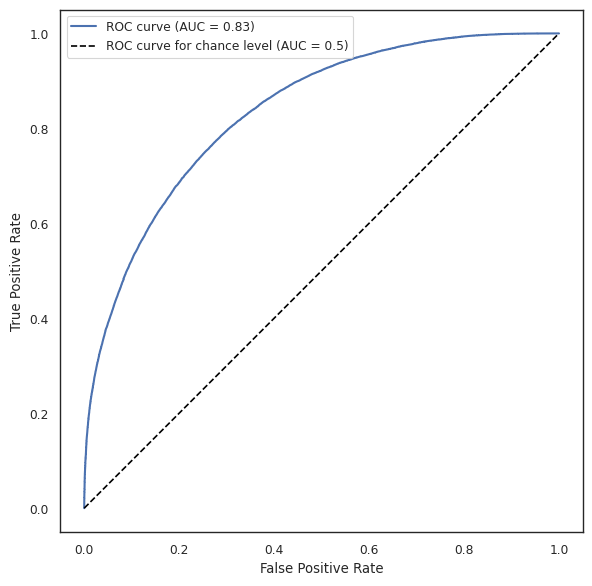

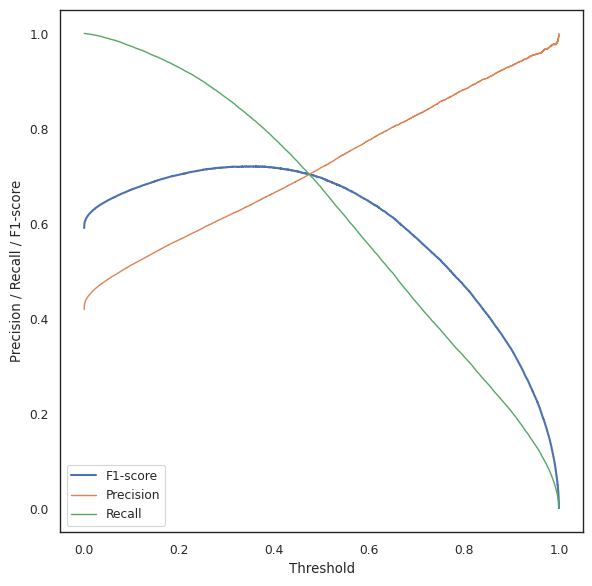

In [18]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## SGD

### Experiment definition

In [ ]:
OPTIMIZER_TYPE = "SGD"
OPTIMIZER_KWARGS = {"momentum": 0.9, "nesterov": True, "weight_decay": 0.01}
LR = 5e-2
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "factor": 0.5,
    "patience": 3,
    "monitor": "val_loss",
    "mode": "min",
}
POSTFIX = "NESTEROV"


RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

### Training

In [ ]:
trainer.fit(lit_model, ckpt_path=None);

### Evaluation and visualization

In [ ]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## RMSprop

### Experiment definition

In [ ]:
OPTIMIZER_TYPE = "RMSprop"
OPTIMIZER_KWARGS = {"weight_decay": 0.005, "momentum": 0.9, "alpha": 0.99}
LR = 1e-2
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ExponentialLR",
    "gamma": 0.95,
}

POSTFIX = "ExponentialLR"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

### Training

In [ ]:
trainer.fit(lit_model);

### Evaluation and visualization

In [ ]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Adagrad

### Experiment definition

In [ ]:
OPTIMIZER_TYPE = "Adagrad"
OPTIMIZER_KWARGS = {}
LR = 1e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 3,
    "monitor": "val_loss",
}

POSTFIX = "ReduceLROnPlateau"
RESULTS_PATH = f"../../results/optimizer_selection/{OPTIMIZER_TYPE}_{LR}_{POSTFIX}"
CKPT_PATH = Path(RESULTS_PATH) / "lightning_logs"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=MIN_DELTA,
        check_finite=True,
        patience=15,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        dirpath=CKPT_PATH,
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

NET = Net(MODEL_FOLDER, INPUT_DIM, HIDDEN_DIM, NUM_CLASSES, dropout=DROPOUT, freeze=FREEZE)


### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

### Training

In [ ]:
trainer.fit(lit_model);

### Evaluation and visualization

In [ ]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "NUM_CLASSES": NUM_CLASSES,
    "INPUT_DIM": INPUT_DIM,
    "HIDDEN_DIM": HIDDEN_DIM,
    "MIN_DELTA": MIN_DELTA,
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## Compare metrics

In [19]:
def parse_tensorboard(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()

    scalars = ea.Tags()["scalars"]

    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

In [22]:
EVENT_FILES = glob("../../results/optimizer_selection/**/lightning_logs/version_*")

In [23]:
res_dict = {}

for f in EVENT_FILES:
    name = Path(f).parent.parent.name
    tmp = parse_tensorboard(f)
    res_dict[name] = tmp

In [24]:
[f for f in list(res_dict.keys()) if f.split("_")[0] == "AdamW"]

['AdamW_0.001_ExponentialLR-amsgrad',
 'AdamW_0.0001_(0.99, 0.999)',
 'AdamW_0.005_ReduceLROnPlateau',
 'AdamW_0.001_(0.85, 0.997)',
 'AdamW_0.001_ExponentialLR']

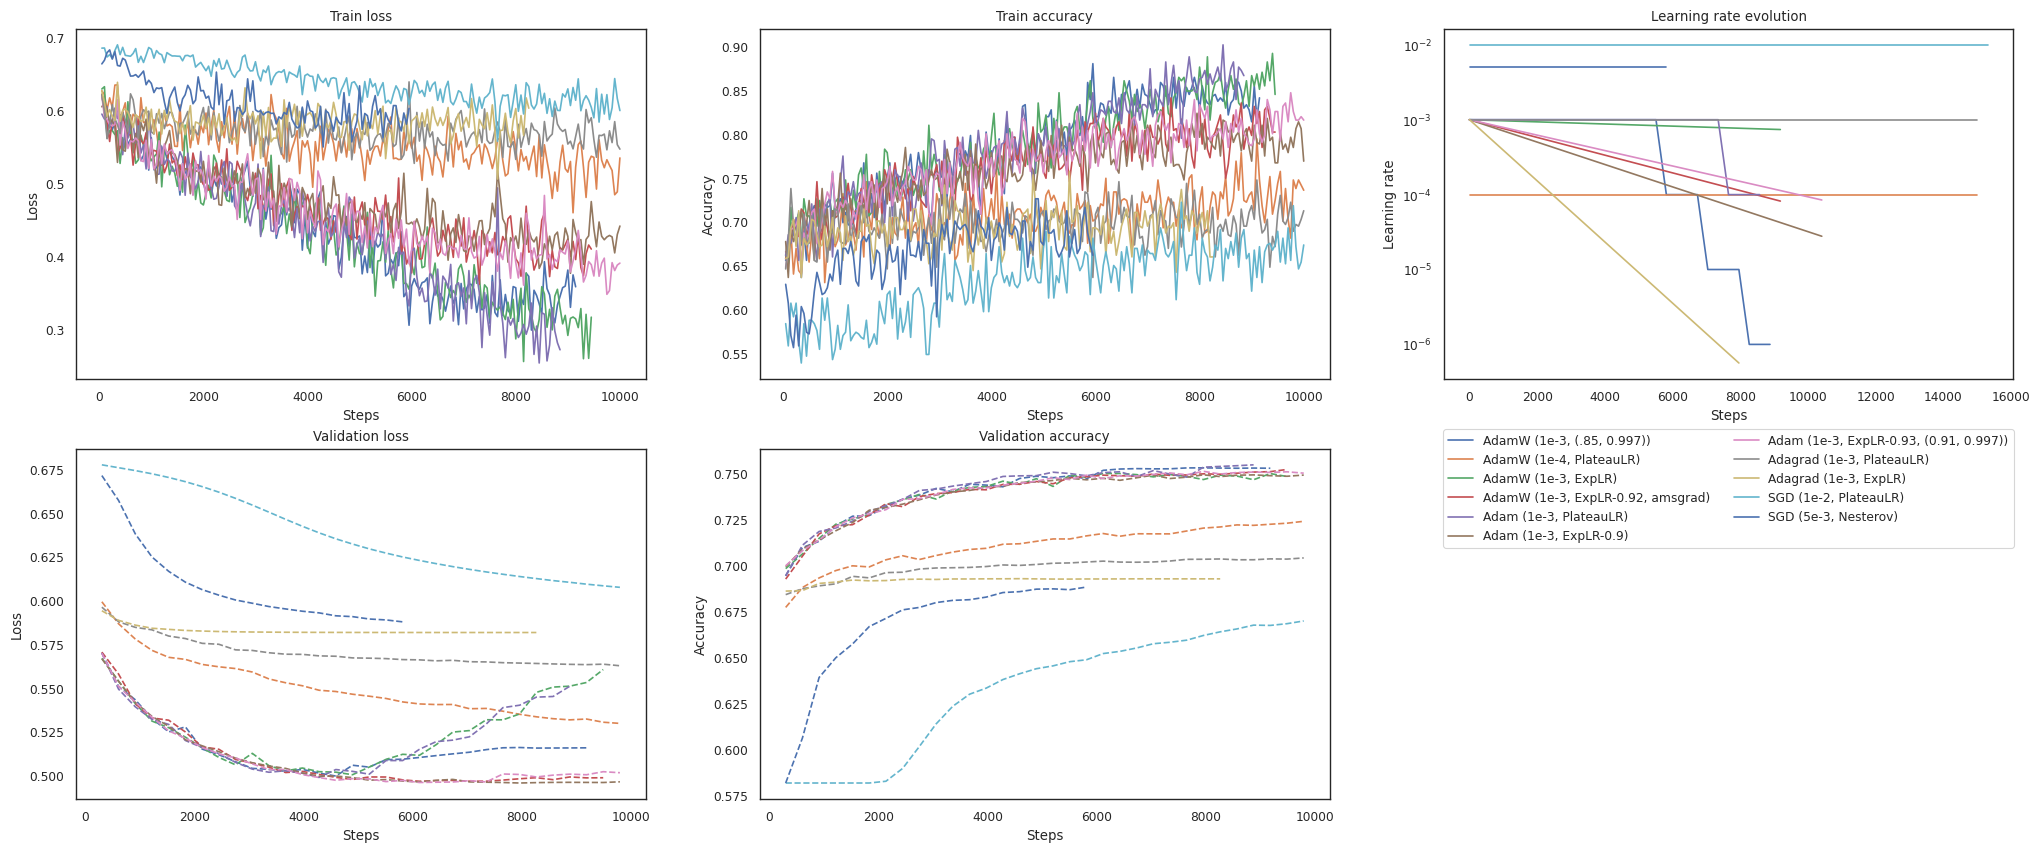

In [25]:
models = {
    "AdamW_0.001_(0.85, 0.997)": "AdamW (1e-3, (.85, 0.997))",
    "AdamW_0.0001_(0.99, 0.999)": "AdamW (1e-4, PlateauLR)",
    "AdamW_0.001_ExponentialLR": "AdamW (1e-3, ExpLR)",
    "AdamW_0.001_ExponentialLR-amsgrad": "AdamW (1e-3, ExpLR-0.92, amsgrad)",
    "Adam_0.001_ReduceLROnPlateau": "Adam (1e-3, PlateauLR)",
    "Adam_0.001_ExponentialLR-0.9": "Adam (1e-3, ExpLR-0.9)",
    "Adam_0.001_ExponentialLR-0.93-(0.91, 0.997)": "Adam (1e-3, ExpLR-0.93, (0.91, 0.997))",
    "Adagrad_0.001_ReduceLROnPlateau": "Adagrad (1e-3, PlateauLR)",
    "Adagrad_0.001_ExponentialLR": "Adagrad (1e-3, ExpLR)",
    "SGD_0.01_ReduceLROnPlateau": "SGD (1e-2, PlateauLR)",
    "SGD_0.005_NESTEROV": "SGD (5e-3, Nesterov)",
}
res_dict_2 = {k: res_dict[k] for k in models}


fig, axs = plt.subplots(2, 3, figsize=(25, 10))

colors = sns.color_palette("deep", len(res_dict))
max_step = 10000

for i, model in enumerate(res_dict_2):
    tmp = res_dict_2[model]

    for k in ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]:
        tmp[k] = tmp[k][tmp[k]["step"] < max_step]

    train_steps = tmp["train_loss"]["step"]
    train_loss = tmp["train_loss"]["value"]
    val_steps = tmp["val_loss"]["step"]
    val_loss = tmp["val_loss"]["value"]
    train_acc = tmp["train_accuracy"]["value"]
    val_acc = tmp["val_accuracy"]["value"]
    lr_key = list(tmp.keys())[1]
    lr_steps = tmp[lr_key]["step"]
    lr_val = tmp[lr_key]["value"]

    axs[0, 0].plot(train_steps, train_loss, label=models[model], color=colors[i])
    axs[1, 0].plot(val_steps, val_loss, color=colors[i], linestyle="--")
    axs[0, 0].set(xlabel="Steps", ylabel="Loss", title="Train loss")
    axs[1, 0].set(xlabel="Steps", ylabel="Loss", title="Validation loss")

    axs[0, 1].plot(train_steps, train_acc, label=models[model], color=colors[i])
    axs[1, 1].plot(val_steps, val_acc, color=colors[i], linestyle="--")
    axs[0, 1].set(xlabel="Steps", ylabel="Accuracy", title="Train accuracy")
    axs[1, 1].set(xlabel="Steps", ylabel="Accuracy", title="Validation accuracy")

    axs[0, 2].plot(lr_steps, lr_val, label=models[model], color=colors[i])
    axs[0, 2].set(
        xlabel="Steps", ylabel="Learning rate", title="Learning rate evolution", yscale="log"
    )
    axs[0, 2].legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)

    axs[1, 2].axis("off")

fig.savefig("../../results/optimizer_selection/loss_evolution.png")

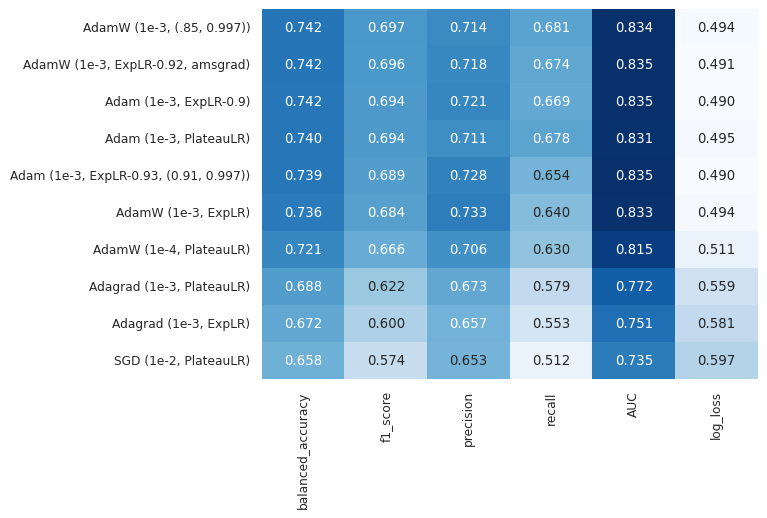

In [26]:
metrics = []

metrics_files = glob("../../results/optimizer_selection/**/metrics.json")
metrics_files = [Path(f) for f in metrics_files]

model_index = [f for f in metrics_files if f.parent.name in models]
model_names = [models[m.parent.name] for m in model_index]

for f in model_index:
    with open(f, "r") as file:
        metrics.append(json.load(file))

res_df = pd.DataFrame(metrics, index=model_names)

g = sns.heatmap(
    res_df[["balanced_accuracy", "f1_score", "precision", "recall", "AUC", "log_loss"]].sort_values(
        "f1_score", ascending=False
    ),
    annot=True,
    fmt=".3f",
    cmap="Blues",
    cbar=False,
)

g.figure.savefig("../../results/optimizer_selection/heatmap.png")